In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
# !conda install -c anaconda seaborn -y

In [3]:
# Transfomer is the first to rely entirely on self-attention to compute representation
# of input and output without using sequence aligned RNNs or ConVs

In [4]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Based for this and my other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process maksed src and tgt sequcence."""
        return self.decode(self.encoder(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        """decoder training also needs target as GT for training...
        inference should not have label(GT)
        """
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [5]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, d_model, vocal):
        super().__init__()
        self.proj = nn.Linear(d_model, vocal)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [6]:
# stacked self-attention and point-wise, fully connected layer for both
# encoder and decoder.

In [7]:
def clones(module, N):
    """Procude N identical layers."""
    return nn.ModuleListt([copy.deepcopy(module) for _ in range(N)])

In [8]:
class Encoder(nn.Module):
    
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        """Pass the input throudh the layer in turn."""
        for layer in self.layers:
            # norm is encoded in each layer
            x = layer(x, mask)
        # The final norm is done after the last norm.
        return self.norm(x)

In [9]:
class LayerNorm(nn.Module):
    
    def __init__(self, features, eps=1e-6):
        super().__init__()
        # every sample and spatial feat location has its
        # own affine parameters.
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, deepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [10]:
class SubLayerConnection(nn.Module):
    
    def __init__(self, size, dropout):
        
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        """Apply residual connection."""
#         return x + self.dropout(sublayer(self.norm(x)))
        return self.norm(x + self.dropout(sublayer(x)))

In [11]:
class EncoderLayer(nn.Module):
    
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        
    def forward(self, x, mask):
        """first go through self_attention, and then sublayer."""
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [12]:
class Decoder(nn.Module):
    """Generic N layer decoder with masking."""
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        # memory comes from encoder.....
        # each time step has its own encoding.
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
            
        return self.norm(x)

In [13]:
# decoder layer has one more multi-head attention over the output of the encoder stack

class DecoderLayer(nn.Module):
    
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """Follow paper.
        
        for training: x should come from target sequence.
        
        for testing: what is x???????
        
        """
        m = memory
        # the first attention should come from the tatget sequence itself
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # the sencond attention should come from input sequence..
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](s, self.feed_forward)

In [14]:
def subsequent_mask(size):
    """Mask out subsequent positions."""
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype(np.uint8)
    # create mask: don't attend future steps..furture words.
    return torch.from_numpy(subsequent_mask) == 0
    

In [15]:
# np.triu
"""
Return a copy of an array with the elements below the k-th diagonal zeroed.
"""

arr = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
print(np.triu(arr, k=0))
print(np.triu(arr, k=1))
print(np.triu(arr, k=-1))

[[1 2 3]
 [0 5 6]
 [0 0 9]
 [0 0 0]]
[[0 2 3]
 [0 0 6]
 [0 0 0]
 [0 0 0]]
[[ 1  2  3]
 [ 4  5  6]
 [ 0  8  9]
 [ 0  0 12]]


In [16]:
print(np.triu(arr, k=1) == 0)

[[ True False False]
 [ True  True False]
 [ True  True  True]
 [ True  True  True]]


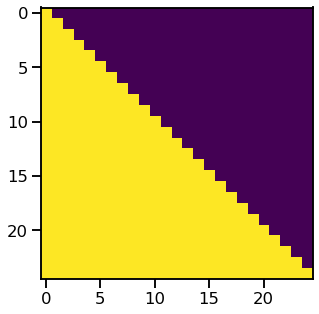

In [17]:
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(25)[0])
# mask examples, only attend previous locations for predictions.

## Attention

attention is to map a query and a set of key-value pair to an output.
The ouput is computed as a weighted sum of the values.

In [18]:
# query and key should have the same dimentions, d_k
# value might have a different dimensions as d_v.
def attention(query, key, value, mask=None, dropout=None):
    
    # d_k is the last dimention of query, key-value
    # d_model // h (h=8)
    d_k = query.shape[-1]
    # compute pairwise query and key
    scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        # boollean filled
        # mask out the zeros.....
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [148]:
query = torch.randn(10, 32, 8, 64)
key = torch.randn(10, 32, 8, 64)
value = torch.randn(10, 32, 8, 64)
torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(64)
p_attn = F.softmax(torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(64), dim=-1)
print(p_attn.shape)
out = torch.matmul(p_attn, value)
print(out.shape, out.transpose(1, 2).shape)



# torch.matmul(query, key.transpose(-1, -2))

torch.Size([10, 32, 8, 8])
torch.Size([10, 32, 8, 64]) torch.Size([10, 8, 32, 64])


In [31]:
query = torch.randn(10, 32, 128)
key = torch.randn(10, 32, 128)
value = torch.randn(10, 32,256)
out, p_attn = attention(query, key, value)

In [32]:
out.shape, p_attn.shape

(torch.Size([10, 32, 256]), torch.Size([10, 32, 32]))

In [33]:
# query and keys could have different numbers, so 

# for similar, additive is similar to dot-product for small-dimentions.
# and additive outperforms dot-product for large-dimensions, without re-scalings.

In [34]:
print("""

# transform input to three subspaces, Q, K, V
W_i_Q \in R_dm_dk
W_i_k \in R_dm_dk
W_i_v \in R_dm_dv

# transform to output

W_h*dv_dm


encoder and decoder should use the same dm, so that they could do attention.


""")



# transform input to three subspaces, Q, K, V
W_i_Q \in R_dm_dk
W_i_k \in R_dm_dk
W_i_v \in R_dm_dv

# transform to output

W_h*dv_dm


encoder and decoder should use the same dm, so that they could do attention.





In [35]:
class MultiHeadedAttention(nn.Module):
    
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        # this "4" is wired.
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        
        # why the first dim is batch?????
        # it should seq-length, right?
        nbatches = query.size(0)
        # 1) do linear projections in batch from d_model tto h x d_k
        query, key, value = \
            # split 'd_model' in 'self.h, self.d_k'
            # attention is done among different time-stepsssss........
            # So this is important to swap between subspace#h and 
            # the total time steps.....
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))]
        
        # 2) apply atttention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "concat" using a view and apply a final linear.
        # swap back between timesteps and h subspacessss....
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linear[-1](x)

In [36]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [37]:
class Embedding(nn.Module):
    
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [38]:
# position embedding should have the same dim as d_model, so they could be summed.

In [45]:
for idx in range(0, 100, 2):
    print(np.sin(10000 / 10000 * (complex(0, idx) / 512)))

0j
0.003906259934115042j
0.007812579473102231j
0.011719018222743221j
0.01562563579063867j
0.019532491787117794j
0.02343964582614794j
0.02734715752624424j
0.031255086511379294j
0.03516349241189298j
0.03907243486540235j
0.04298197351771159j
0.04689216802372219j
0.05080307804834318j
0.05471476326740154j
0.0586272833685528j
0.06254069805219181j
0.06645506703236367j
0.07037045003767493j
0.0742869068122049j
0.07820449711641739j
0.08212328072807246j
0.08604331744313871j
0.08996466707670552j
0.09388738946389587j
0.09781154446077933j
0.10173719194528538j
0.10566439181811711j
0.10959320400366518j
0.1135236884509222j
0.11745590513439755j
0.12138991405503241j
0.12532577524111546j
0.12926354874919863j
0.13320329466501368j
0.13714507310438895j
0.14108894421416662j
0.14503496817312062j
0.14898320519287472j
0.15293371551882134j
0.15688655943104096j
0.16084179724522163j
0.16479948931357963j
0.16875969602578023j
0.1727224778098591j
0.17668789513314453j
0.18065600850317987j
0.18462687846864698j
0.1886005

In [130]:
class PositionEmbedding(nn.Module):
    
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        # compute the positional encoding in log space
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, ::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
    
    def forward(self, x):
        print(self.pe.shape)
#         print(self.pe[:, x.size(1)].shape)
        return x + self.pe[:, :x.size(1)]
    

torch.Size([1, 5000, 20])


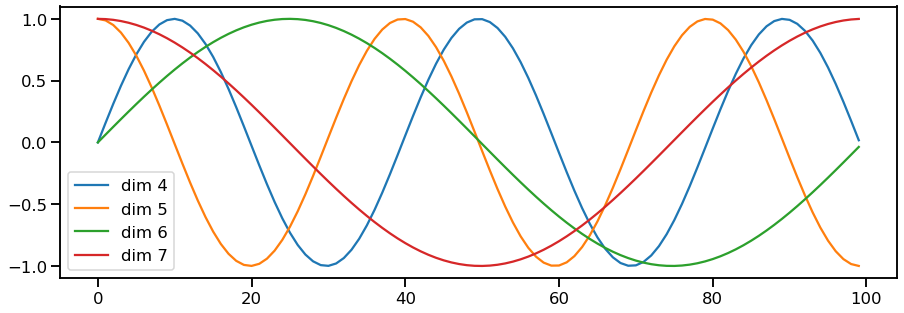

In [131]:
plt.figure(figsize=(15, 5))
pe = PositionEmbedding(20, 0)
y = pe(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].numpy())
plt.legend([f"dim {p}" for p in range(4, 8)])

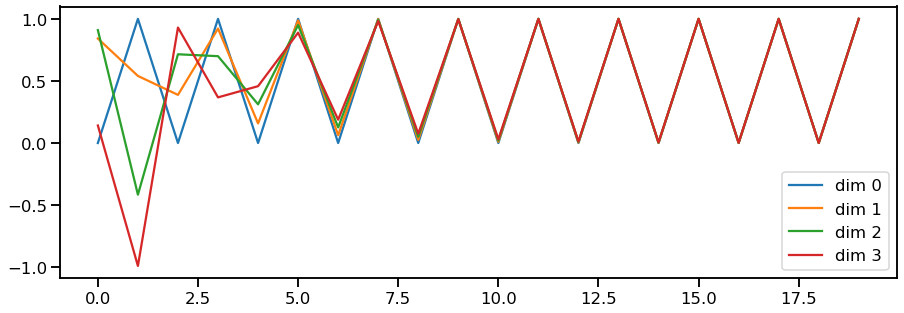

In [136]:
plt.figure(figsize=(15, 5))
pe = PositionEmbedding(20, 0)

plt.plot(np.arange(20), pe.pe[0, 0:4].numpy().T)
plt.legend([f"dim {p}" for p in range(4)])

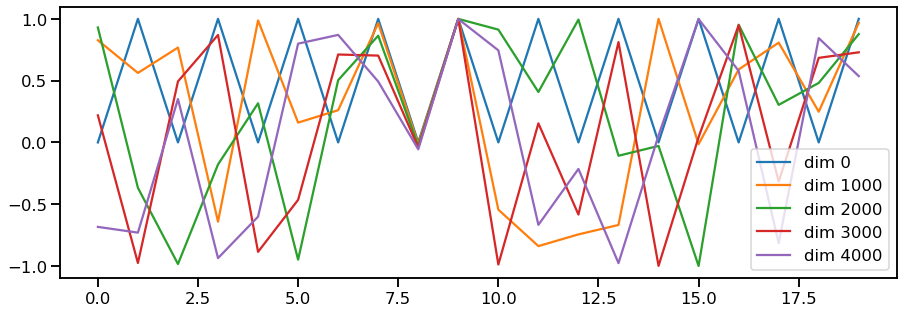

In [137]:
plt.figure(figsize=(15, 5))
pe = PositionEmbedding(20, 0)

plt.plot(np.arange(20), pe.pe[0, range(0, 5000, 1000)].numpy().T)
plt.legend([f"dim {p}" for p in range(0, 5000, 1000)])

In [138]:
def make_model(src_vocab, tgt_vocal, N=6,
              d_model=512, d_ff=2048, h=8, dropout=0.1):
    
    c = copy.deepcopy()
    attn = MultiHeadedAttention(h, d_model)
    # two FC layers with one relu.
    ff = PositionwiseFeedForward(h, d_model)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLaher(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
            
    return model

In [154]:
x = torch.randn(10, 8, 20, 64)
m = torch.randn(10, 8, 30, 64)
m = torch.randn(10, 8, 30, 64)



print(torch.matmul(x, m.transpose(-1, -2)).shape)
print(torch.matmul(torch.matmul(x, m.transpose(-1, -2)), m).shape)

torch.Size([10, 8, 20, 30])
torch.Size([10, 8, 20, 64])


In [110]:
torch.exp(torch.arange(0, 10, 2) / 10  * (-math.log(10000))) * 1

tensor([1.0000e+00, 1.5849e-01, 2.5119e-02, 3.9811e-03, 6.3096e-04])

In [111]:
torch.sin(torch.exp(torch.arange(0, 10, 2) / 10  * (-math.log(10000))) * 10)

tensor([-0.5440,  0.9999,  0.2486,  0.0398,  0.0063])

In [116]:
torch.sin(torch.tensor(math.pi / 2))

tensor(1.)

In [97]:
import yaml
# every position could generate different encoding in different dim-index.
with open("/Users/guoxian/workspace/bifrost/xpilot_vision/utf2/yaml_example.yaml", "r") as fid:
    result = yaml.load_all(fid)
for subdoc in result:
    print(subdoc)

<ipython-input-97-ceac42e77132>:5: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  for subdoc in result:


ValueError: I/O operation on closed file.

In [95]:
for subdoc in result:
    print(subdoc)

<ipython-input-95-c9768de8bd55>:1: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  for subdoc in result:


ValueError: I/O operation on closed file.

In [60]:
import math

In [61]:
result["nan"], result["nan_"]

('nan', nan)

In [65]:
math.isnan(result["nan"])

TypeError: must be real number, not str

In [66]:
math.isnan(result["nan_"])

True

In [68]:
math.isinf(result["inf"])

TypeError: must be real number, not str

In [69]:
math.isinf(result["inf_"])

True

In [72]:
result["foo"], result["bar"]

('this is not a normal string\n', 'this is not a normal string\\n')

In [73]:
print(result["foo"])

this is not a normal string



In [74]:
print(result["bar"])

this is not a normal string\n


In [79]:
result["ml"]

'mulit lline result hhaa dkhel llow world\n'